In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')
import os

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
data = pd.read_csv('train.csv')
data = reduce_mem_usage(data)

Memory usage of dataframe is 300800128.00 MB
Memory usage after optimization is: 72829816.00 MB
Decreased by 75.8%


In [4]:
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')

In [6]:
from sklearn.model_selection import KFold

In [7]:
X_train = data.drop(['id','issueDate','isDefault'], axis=1)

In [8]:
y_train = data['isDefault']

In [9]:
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [10]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
}

"""使用训练集数据进行模型训练"""
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	valid_0's auc: 0.719218


未调参前lightgbm单模型在验证集上的AUC：0.7192184551973573


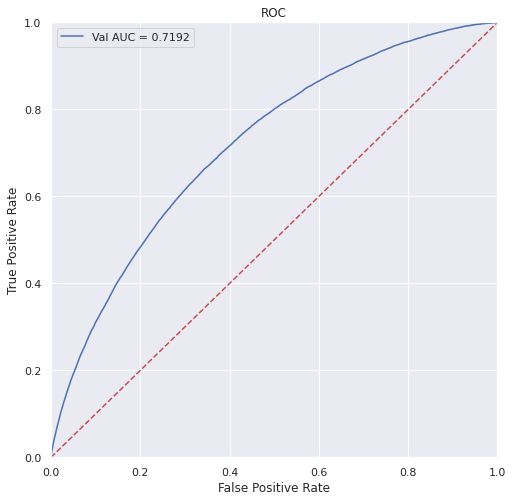

<Figure size 432x288 with 0 Axes>

In [13]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

"""预测并计算roc的相关指标"""
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('未调参前lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()